<a href="https://colab.research.google.com/github/HakimSkaik/Autonomous-Car/blob/main/Behavioural_Cloning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
!git clone https://github.com/HakimSkaik/track

fatal: destination path 'track' already exists and is not an empty directory.


In [95]:
!ls track

driving_log.csv  IMG


In [96]:
!pip3 install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.layers import Conv2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [98]:
datadir = 'track'
columns =['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  \
0  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_21_00_50_28_554.jpg   
1  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_21_00_50_28_654.jpg   
2  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_21_00_50_28_756.jpg   
3  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_21_00_50_28_857.jpg   
4  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_21_00_50_28_958.jpg   

                                                                      left  \
0   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_21_00_50_28_554.jpg   
1   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_21_00_50_28_654.jpg   
2   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_21_00_50_28_756.jpg   
3   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_21_00_50_28_857.jpg   
4   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_21_00_50_28_958.jpg   

                                                                      right  \
0   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_21_00_50_28_554.jpg   
1   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_21_00_50_28_654.jpg   
2   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_21_00_50_28_756.jpg   
3   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_21_00_50_28_857.jpg   
4   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_21_00_50_28_958.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000079  
1  0.0       0.0       0.0      0.000081  
2  0.0       0.0       0.0      0.000079  
3  0.0       0.0       0.0      0.000081  
4  0.0       0.0       0.0      0.000079

In [99]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()  

center                              left  \
0  center_2022_10_21_00_50_28_554.jpg  left_2022_10_21_00_50_28_554.jpg   
1  center_2022_10_21_00_50_28_654.jpg  left_2022_10_21_00_50_28_654.jpg   
2  center_2022_10_21_00_50_28_756.jpg  left_2022_10_21_00_50_28_756.jpg   
3  center_2022_10_21_00_50_28_857.jpg  left_2022_10_21_00_50_28_857.jpg   
4  center_2022_10_21_00_50_28_958.jpg  left_2022_10_21_00_50_28_958.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2022_10_21_00_50_28_554.jpg  0.0       0.0       0.0      0.000079  
1  right_2022_10_21_00_50_28_654.jpg  0.0       0.0       0.0      0.000081  
2  right_2022_10_21_00_50_28_756.jpg  0.0       0.0       0.0      0.000079  
3  right_2022_10_21_00_50_28_857.jpg  0.0       0.0       0.0      0.000081  
4  right_2022_10_21_00_50_28_958.jpg  0.0       0.0       0.0      0.000079

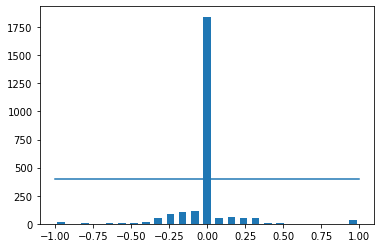

In [100]:
num_bins = 25
samples_per_bin= 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 2538
removed: 1444
remaining: 1094


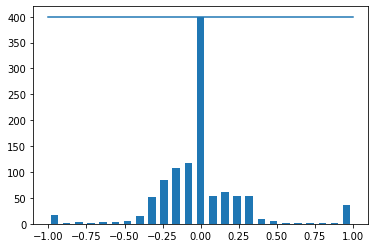

In [101]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))  

In [102]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2022_10_21_00_50_29_562.jpg
left        left_2022_10_21_00_50_29_562.jpg  
right       right_2022_10_21_00_50_29_562.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0.0                               
speed       0.000081                          
Name: 10, dtype: object


In [103]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 2625
Valid Samples: 657


Text(0.5, 1.0, 'Validation set')

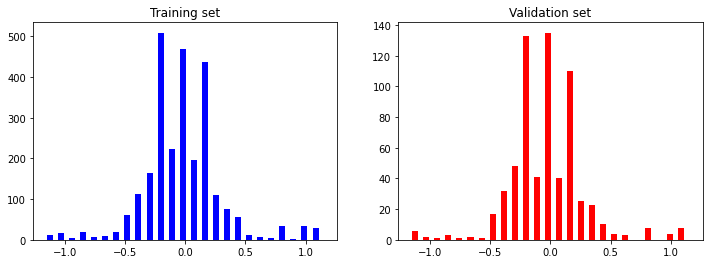

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [105]:
def zoom(image):
  zoom = iaa.Affine(scale = (1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

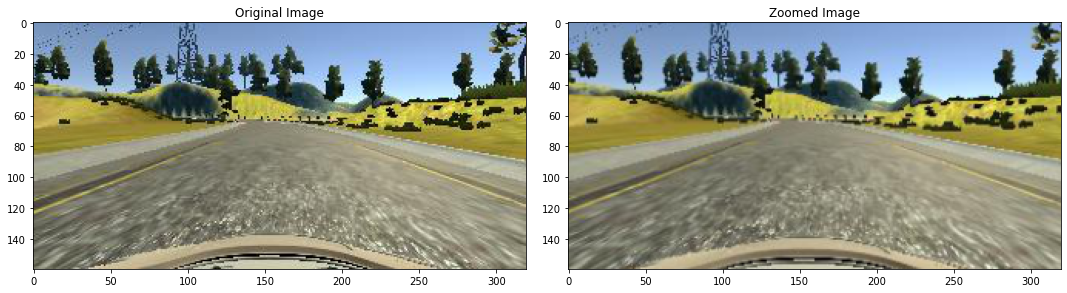

In [106]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [107]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image


Text(0.5, 1.0, 'Panned Image')

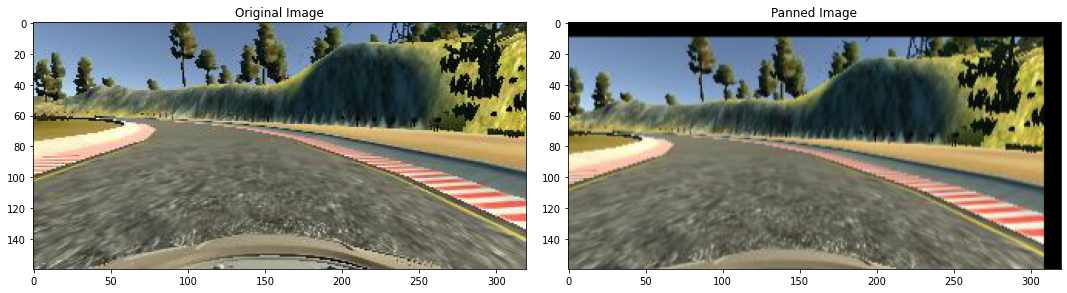

In [108]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [109]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image


Text(0.5, 1.0, 'Brightness Altered Image')

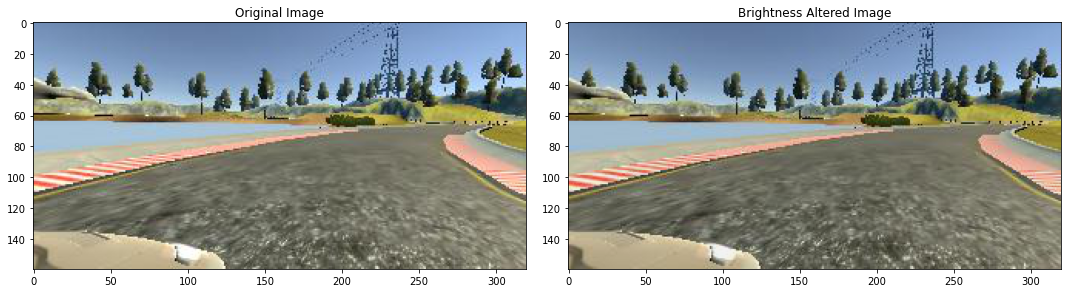

In [110]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [111]:
def img_random_flip(image, steering_angle):
  image= cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.1045131')

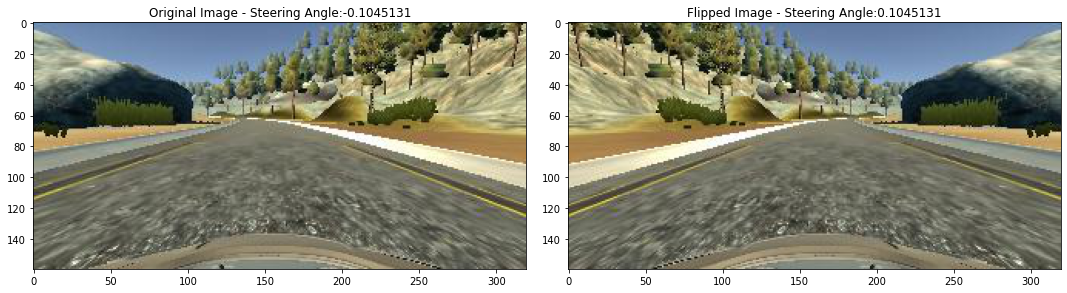

In [112]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [113]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() <0.5:
    image = pan(image)
  if np.random.rand() <0.5:
    image = zoom(image)
  if np.random.rand() <0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

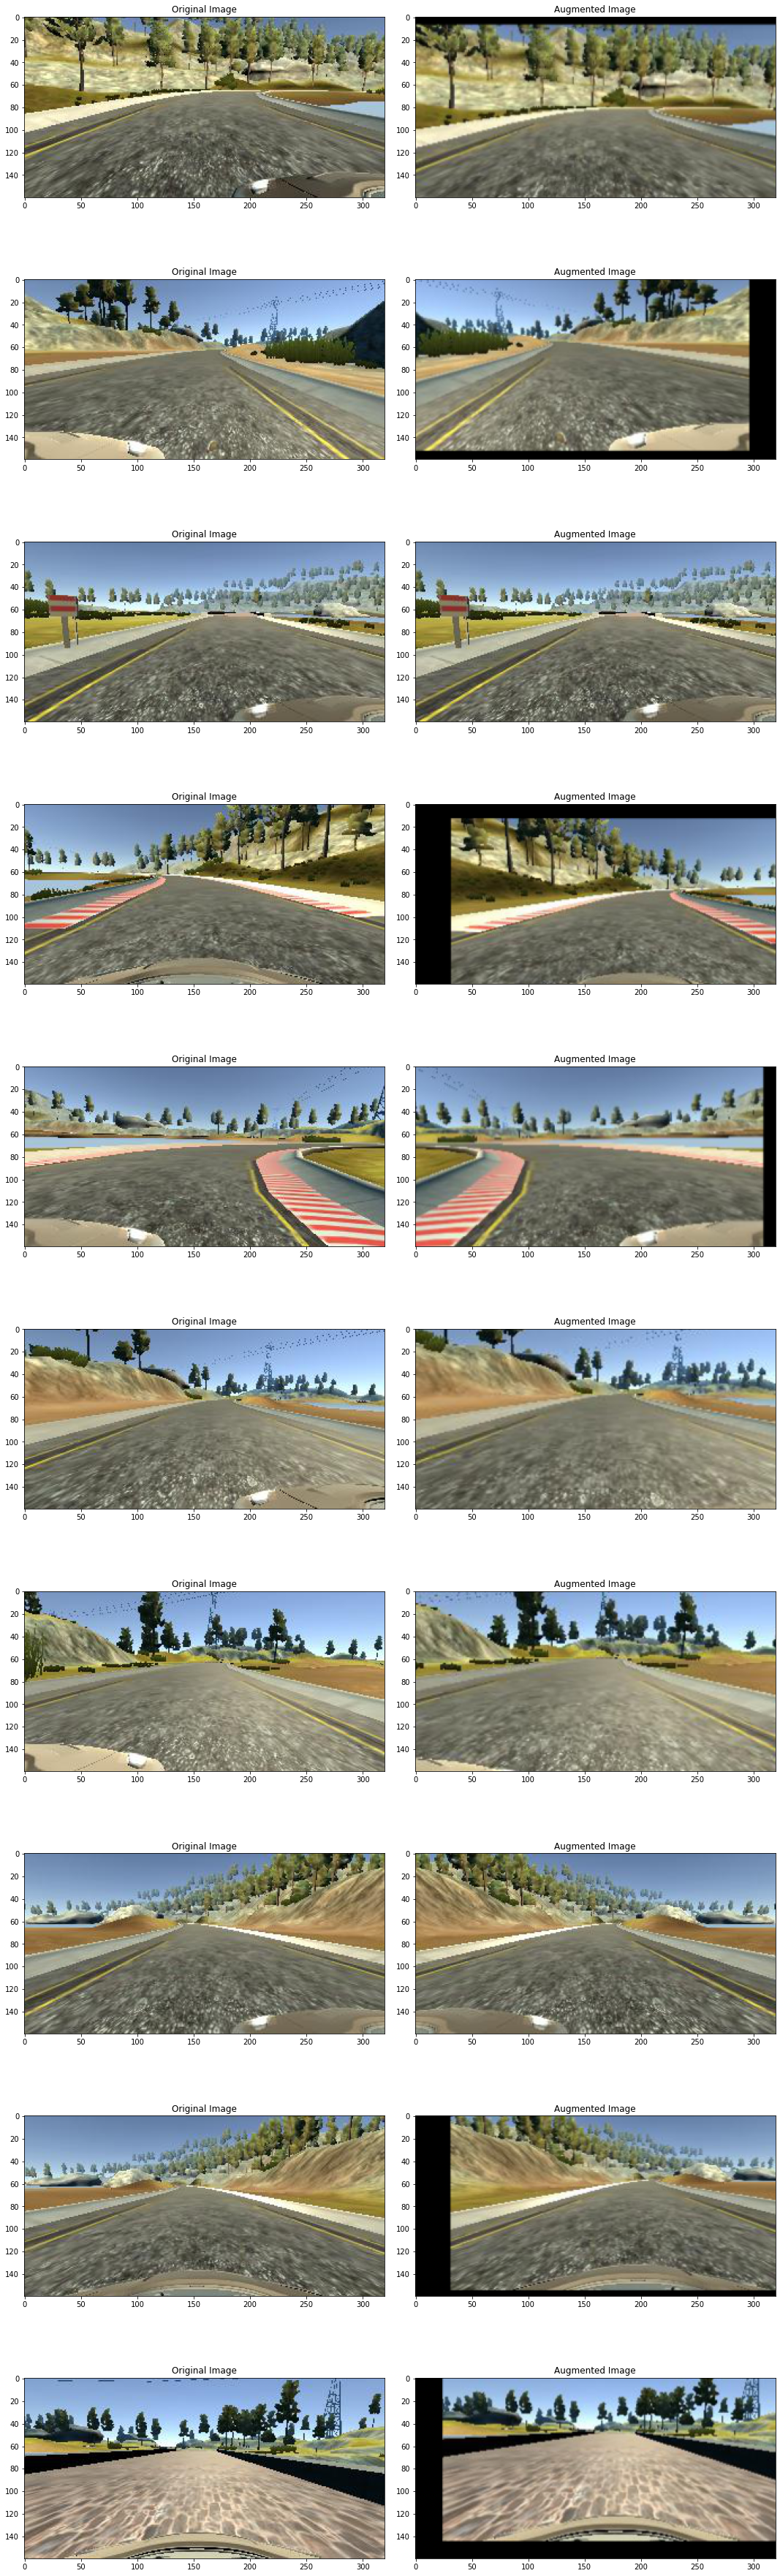

In [114]:
ncol = 2
nrow= 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [115]:
def img_preprocess(img):
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed image')

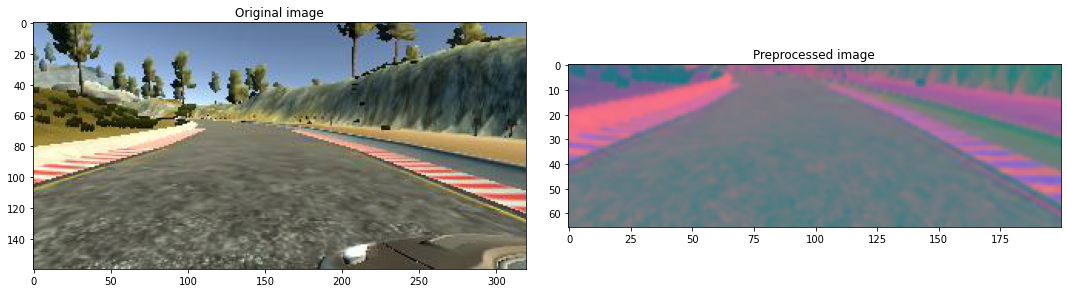

In [116]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize= (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed image")

In [117]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1.0, 'Validation Image')

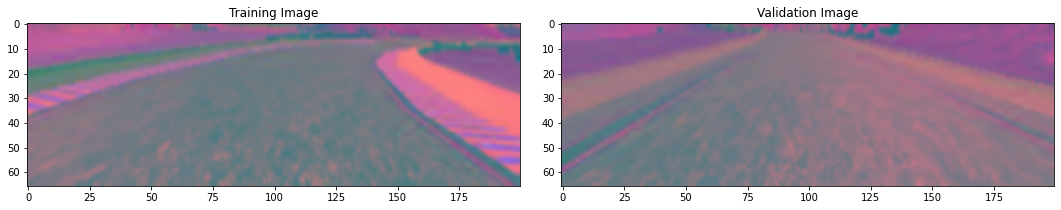

In [118]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [119]:
def nvidia_model():
 model = Sequential()
 model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
 model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
 model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
 model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
 model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
#  model.add(Dropout(0.5))
 
 model.add(Flatten())
 model.add(Dense(100, activation='elu'))
#  model.add(Dropout(0.5))

 model.add(Dense(50, activation='elu'))
#  model.add(Dropout(0.5))

 model.add(Dense(10, activation ='elu'))
 model.add(Dense(1))
 
 optimizer= Adam(learning_rate=1e-4)
 model.compile(loss='mse', optimizer=optimizer)
 return model

In [120]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
                                                                 
 dense_12 (Dense)            (None, 100)              

In [121]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
300/300 [==============================] - 227s 751ms/step - loss: 0.1169 - val_loss: 0.0644
Epoch 2/10
300/300 [==============================] - 224s 749ms/step - loss: 0.0707 - val_loss: 0.0559
Epoch 3/10
300/300 [==============================] - 226s 753ms/step - loss: 0.0662 - val_loss: 0.0467
Epoch 4/10
300/300 [==============================] - 224s 748ms/step - loss: 0.0584 - val_loss: 0.0502
Epoch 5/10
300/300 [==============================] - 225s 751ms/step - loss: 0.0558 - val_loss: 0.0464
Epoch 6/10
300/300 [==============================] - 232s 773ms/step - loss: 0.0494 - val_loss: 0.0415
Epoch 7/10
300/300 [==============================] - 222s 742ms/step - loss: 0.0514 - val_loss: 0.0382
Epoch 8/10
300/300 [==============================] - 223s 742ms/step - loss: 0.0507 - val_loss: 0.0359
Epoch 9/10
300/300 [==============================] - 222s 742ms/step - loss: 0.0461 - val_loss: 0.0429
Epoch 10/10
300/300 [==============================] - 223s 743m

Text(0.5, 0, 'Epoch')

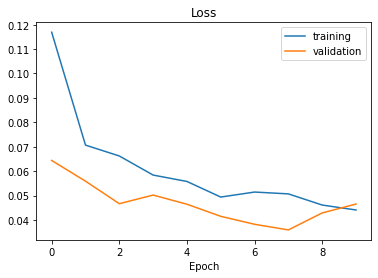

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [123]:
model.save('model.h5')

In [124]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>